#DT2470 Lab 02: Synchronization and rhythm

by Andre Holzapfel

In this lab you will choose to **either** do exercises regarding synchronization (chapter 3), **or** rhythm and tempo processing (chapter 6). We agree that doing both would be too much work (for this year), but you will have the code for the solutions for both anyway!

Again, you can use whatever software you want for your own implementation, but I use python in my explanations, and two external libraries in python need to be used in this Lab. Just as Bob, I am basically learning Python by working on this lab, so excuse my bad programming. (I am a bad programmer independent of language, anyway.)

Your task is to reproduce all shown figures with your code (or show the equivalent plots for your own audio files, if you use different ones). Also, provide short answers to the questions in the text.

##Audio samples:

In my examples I use file from the following google folder:

https://drive.google.com/drive/folders/1TGj4ZcEgdGXt9Eko2qViiiKWkUDDewbL?usp=sharing

You can copy these files to your own google folder and use them as explained in Lab 1.

At some points I will ask you to use some audio examples of your own. Be creative...the goal is to check where systems work or fail, and understand (to some extent) those behaviors.

## Code preparations

As for Lab 1, you need to have some external libraries also here:

**<font color='red'>DISCLAIMER!!!:</font> Error in Lab 3 Description**

This results that the pre-done displayed images are wrong. The error is that the magnitudes from the STFT is not calculated as ABS(X^2), instead ABS(X). To simulate these images, we have also used ABS(X) instead of ABS(X^2). However, we want to emphasize the fact that we know how to do it properly.  

In [ ]:
# Install a python library for working with audio files, named pydub
!pip install pydub



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#other preparations!
import os, sys
from scipy import signal
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display


### Google drive:

you need to adapt the following code to use the audio files that you copied to your google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/labdata"

cmajor_piano.wav  cretansyrtos.wav	 drumloop120_mono.wav  Kafene1.wav
Cmajor_sung.wav   cymbal1_2k_100bpm.wav  flute-c-major.wav     Kafene2.wav


# 1. Synchronisation

Complete the tasks in this part, if you want to focus on the synchronisation (but have a look at the rhythm part below before you decide!).

In [ ]:
def pydub_to_np(audio):
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape(-1, audio.channels) / (
            1 << (8 * audio.sample_width - 1))


In [ ]:
def ms_to_samples(x, sound):
  return int(x*sound.frame_rate/1000)

## Part 1.1 Warming up

Choose two music sound files that can be considered as interpretations of the same "tune". In my example I used the cmajor_piano.wav and Cmajor_sung.wav, where a C-major scale is performed, once on piano and once sung. For the beginning, choose some excerpts, and not complete pieces, in order to get started.

Read the sound files to a numpy array, and plot the two waveforms. (You did that in Lab 1 too).

Below the waveform I get for the piano file: ![waveform](https://drive.google.com/uc?id=1nt5lUZ1IWO8nWDx2mTdddz2pI9CuBfTq)


In [ ]:
cmajor_piano_pydub = pydub.AudioSegment.from_file("/content/drive/MyDrive/labdata/cmajor_piano.wav", 
                                                        format="wav")
cmajor_sung_pydub = pydub.AudioSegment.from_file("/content/drive/MyDrive/labdata/Cmajor_sung.wav", 
                                                        format="wav")
cmajor_piano_sec = int(cmajor_piano_pydub.duration_seconds)
cmajor_sung_sec = int(cmajor_sung_pydub.duration_seconds)

cmajor_piano_fr = cmajor_piano_pydub.frame_rate
cmajor_sung_fr = cmajor_sung_pydub.frame_rate

cmajor_piano = pydub_to_np(cmajor_piano_pydub).reshape(-1)
cmajor_sung = pydub_to_np(cmajor_sung_pydub).reshape(-1)

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

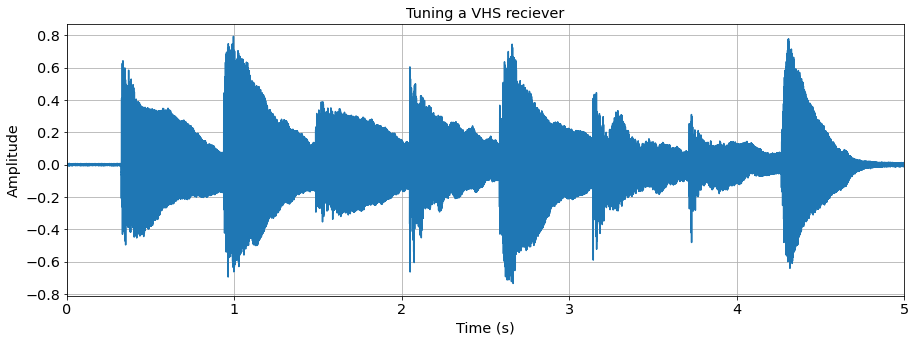

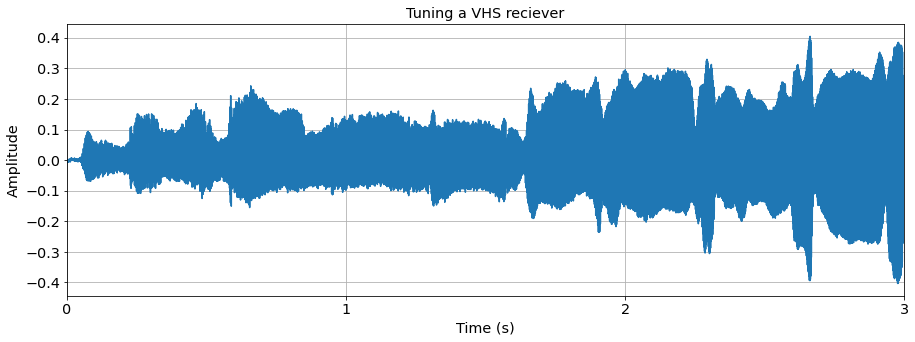

In [ ]:
plt.plot(cmajor_piano)
plt.title("Tuning a VHS reciever")
plt.margins(x=0)
plt.xticks(np.arange(0,len(cmajor_piano)+1,
                     int(len(cmajor_piano)/cmajor_piano_sec)), 
           np.arange(0,cmajor_piano_sec+1,1))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

plt.plot(cmajor_sung)
plt.title("Tuning a VHS reciever")
plt.margins(x=0)
plt.xticks(np.arange(0,len(cmajor_sung)+1,
                     int(len(cmajor_sung)/cmajor_sung_sec)), 
           np.arange(0,cmajor_sung_sec+1,1))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

## Part 1.2 Compute the spectral magnitude

For both signals compute a Short-time Fourier transform (STFT), and plot their magnitude spectra (as in equation 3.1. Use the code from Lab 1 as starting point). Note: Since you are focusing on tonal content in the Chroma features, use a long window (about 100ms).

The magnitude spectrum for the piano example is shown below. 

Question: why do we see so few high-frequency components? (Hint: in lab 1 you plotted db magnitude spectra).

![](https://drive.google.com/uc?id=1_fEgRgIG0pPzCiNa6Pqz5lDfk-vfGloX)

In [ ]:
nperseg1 = ms_to_samples(100, cmajor_piano_pydub)
nperseg2 = ms_to_samples(100, cmajor_sung_pydub)

nhop1 = ms_to_samples(10, cmajor_piano_pydub)
nhop2 = ms_to_samples(10, cmajor_sung_pydub)
noverlap1 = nperseg1 - nhop1
noverlap2 = nperseg2 - nhop2

f1, t1, Zxx1 = signal.stft(cmajor_piano,
                           fs = cmajor_piano_pydub.frame_rate,
                           nperseg = nperseg1,
                           noverlap = noverlap1,
                           window = "hann", 
                           return_onesided = True)

f2, t2, Zxx2 = signal.stft(cmajor_sung,
                           fs = cmajor_sung_pydub.frame_rate,
                           nperseg = nperseg2,
                           noverlap = noverlap2,
                           window = "hann", 
                           return_onesided = True)

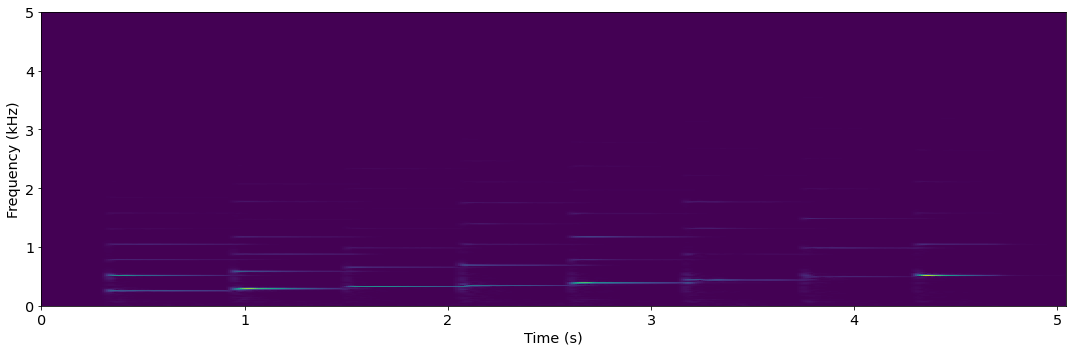

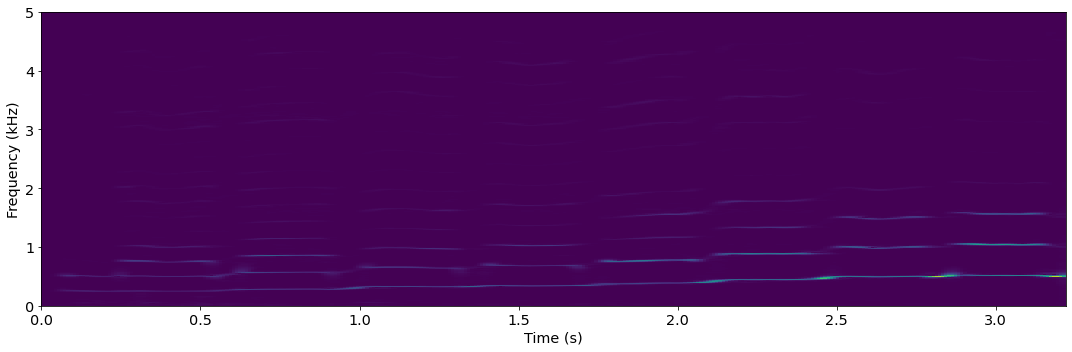

In [ ]:
plt.pcolormesh(t1, f1/1000, np.abs(Zxx1))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.ylim((0,5))
plt.tight_layout()
plt.show()

plt.pcolormesh(t2, f2/1000, np.abs(Zxx2), shading = "cividis")
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.ylim((0,5))
plt.tight_layout()
plt.show()

Question: why do we see so few high-frequency components?

Answer: The magnitudes of the STFT are not clearly visable as the magnitude has a exponential structure. Therefore, we will see high-frequency components if we were to transform the magnitudes to decibel (logarithm) instead. 

## Part 1.3 Compute a log-frequency spectrogram

Now, transform the linear frequency axis into a logarithmic one (equation 3.4), and plot the resulting log-frequency spectra for both signals.

Hint: you need to assign the frequencies of the STFT coefficients to the desired pitch bins of the 12-tone resolution (equations 3.2 and 3.3, and the related text in the book help). Unless you are a good numpy programmer (I am not), you will need some loop in that code...

My piano log-f spectrogram looks as shown below.

Question: why do the low-frequency regions look so spread-out and smeary?

![](https://drive.google.com/uc?id=1pxHK7CVEX438DB4BAASGEiU3Qi-hw3Sc)



In [ ]:
def f_pitch(p):
  return 2 ** ((p - 69) / 12) * 440

def pitch_pool(p, Fs, N):
  lower = f_pitch(p - 0.5)
  upper = f_pitch(p + 0.5)

  k = np.arange(N//2+1)
  fk_coef = k*Fs/N
  return k[(fk_coef >= lower) & (fk_coef < upper)]
def mdi_pitch(X, Fs, N):
  n = 128
  Y_lf = np.zeros((n, X.shape[1]))
  for p in range(n):
      k = pitch_pool(p, Fs, N)
      Y_lf[p, :] = X[k, :].sum(axis=0)
  f_coef_pitch = np.arange(n)
  return Y_lf, f_coef_pitch

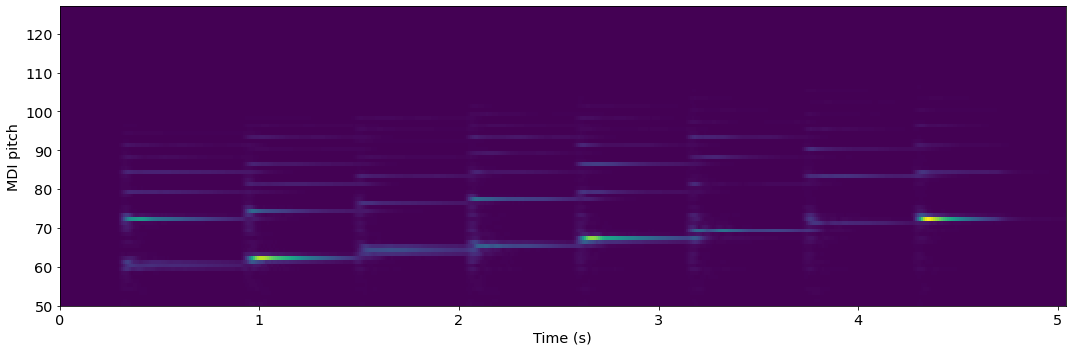

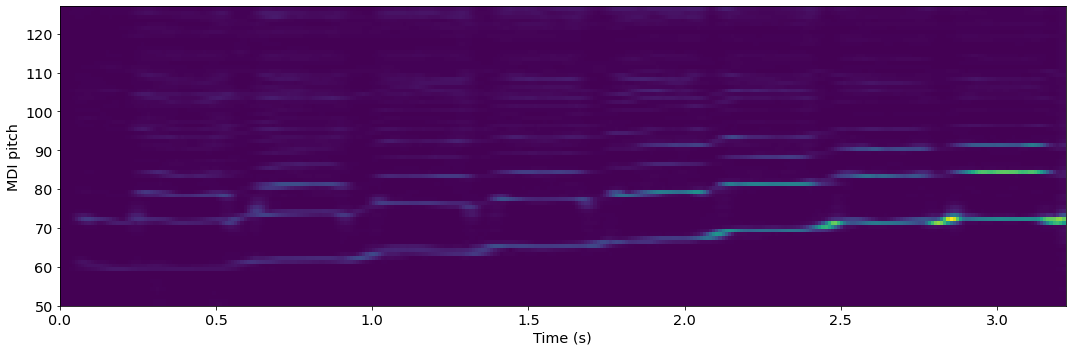

In [ ]:
Y_lf_1, f_coef_pitch_1 = mdi_pitch(np.abs(Zxx1), cmajor_piano_fr, nperseg1)
plt.pcolormesh(t1, f_coef_pitch_1, Y_lf_1)
plt.ylabel("MDI pitch")
plt.xlabel("Time (s)")
plt.ylim(50)
plt.tight_layout()
plt.show()

Y_lf_2, f_coef_pitch_2 = mdi_pitch(np.abs(Zxx2), cmajor_sung_fr, nperseg2)
plt.pcolormesh(t2, f_coef_pitch_2, Y_lf_2)
plt.ylabel("MDI pitch")
plt.xlabel("Time (s)")
plt.ylim(50)
plt.tight_layout()
plt.show()

Question: why do the low-frequency regions look so spread-out and smeary?

Answer: It looks like that as these frequencies are pooled together which creates a smaller dimension for the specific frequencies and some overlapping occurs.

## Compute the chromagram

The chromagram is a feature that captures well harmonic and melodic development in a sound file. You will compute these features, to apply a synchronization (DTW) algorithm to them.



1.   Compute the chromagram according to equation 3.6

![](https://drive.google.com/uc?id=1Hj26wZ2WHufe1DkZqZoFrJ06kS7y8msS)

2.   Apply logarithmic compression to the chromagram. This will be your input feature for the DTW (my example uses gamma=100).

![](https://drive.google.com/uc?id=1eX8WhSmn6XxI8sIXxfRxdnssSrf2kICT)







Part 1

In [ ]:
def chroma_features(Y_lf):
  cf = 12
  C = np.zeros((cf, Y_lf.shape[1]))
  p = np.arange(128)

  for c in range(cf):
      filter = (p % cf) == c
      C[c, :] = Y_lf[filter, :].sum(axis=0)
  return C


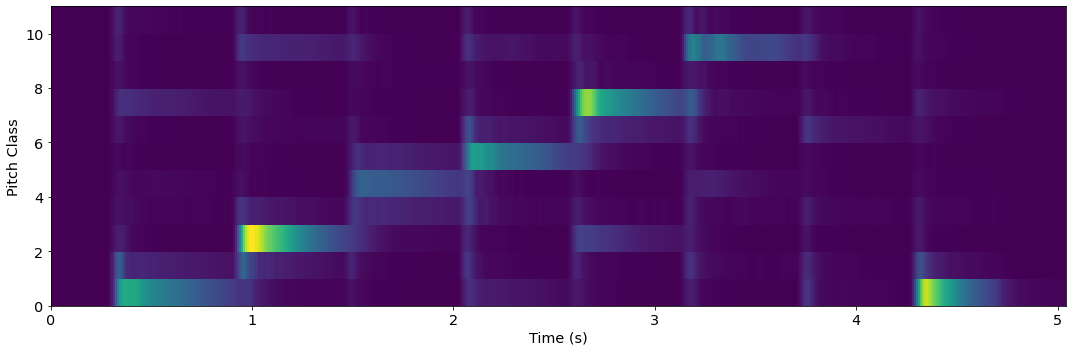

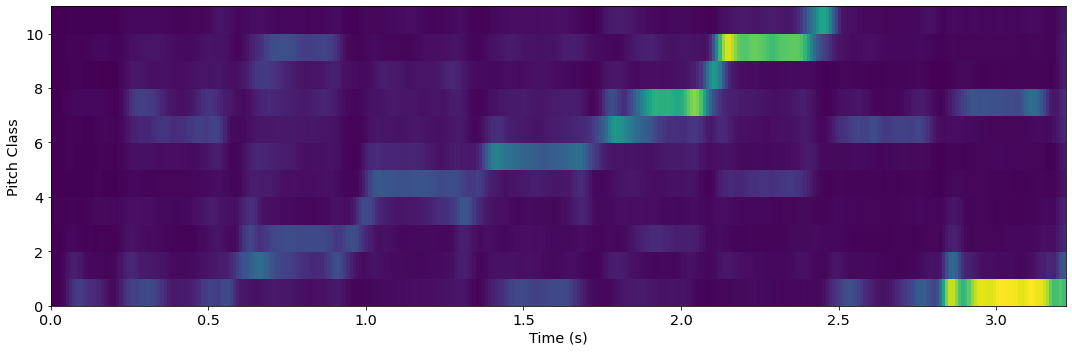

In [ ]:
C1 = chroma_features(Y_lf_1)
plt.pcolormesh(t1, np.arange(12), C1)
plt.ylabel("Pitch Class")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

C2 = chroma_features(Y_lf_2)
plt.pcolormesh(t2, np.arange(12), C2)
plt.ylabel("Pitch Class")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

Part 2

In [ ]:
def log_compr(X, gamma = 100):
  return np.log10(1+gamma*X)

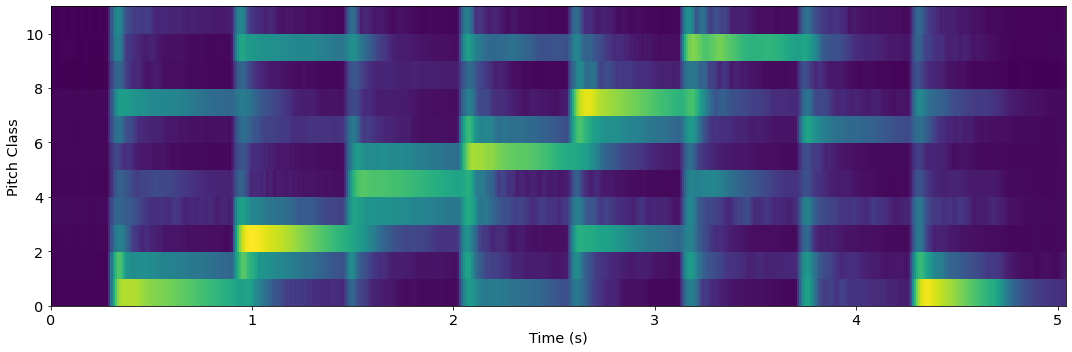

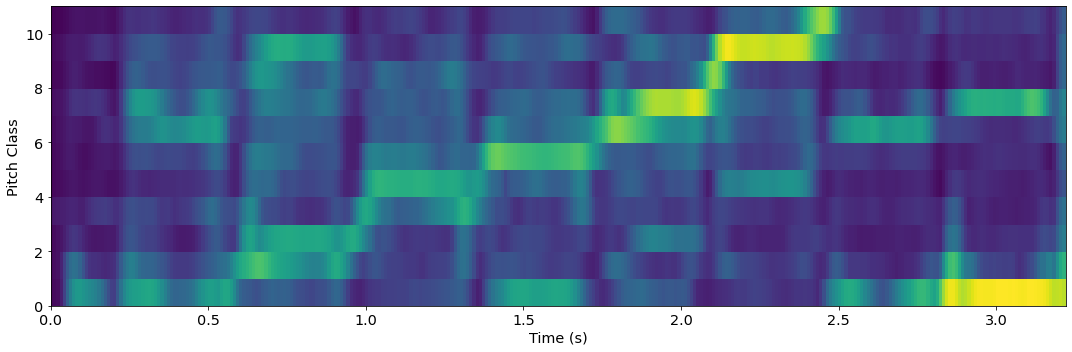

In [ ]:
log_c1 = log_compr(C1)
plt.pcolormesh(t1, np.arange(12), log_c1 )
plt.ylabel("Pitch Class")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

log_c2 = log_compr(C2)
plt.pcolormesh(t2, np.arange(12), log_c2)
plt.ylabel("Pitch Class")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

## Part 1.4 Compute the synchronization

To this end, you will use the DTW as provided by the librosa library. You can see how to use it in the following code:

https://librosa.github.io/librosa_gallery/auto_examples/plot_music_sync

You can use your two computed chromagrams as inputs X and Y to this function, as they are. Compute the synchronization, and plot the path over the obtained cost matrix D. Your code should start somehow like:

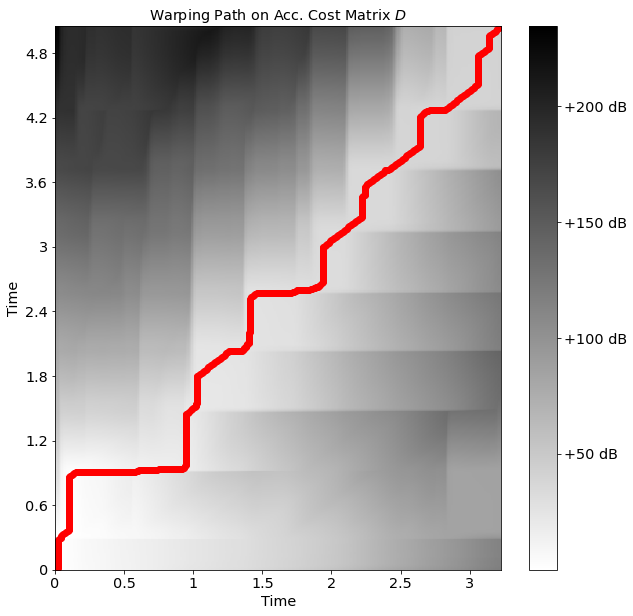

In [ ]:
import librosa
import librosa.display

D, wp, steps = librosa.sequence.dtw(X=C1, Y=C2, metric='cosine', return_steps=True)
wp_s = np.asarray(wp) * nhop1 / cmajor_piano_fr


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', 
                         sr = cmajor_piano_fr, 
                         hop_length= nhop1,
                         ax = ax)

imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
ax.set(title='Warping Path on Acc. Cost Matrix $D$')

fig.colorbar(imax, ax=ax, format="%+2.f dB")
plt.show()

The plot I obtain when synchronizing the piano and the voice example:

![](https://drive.google.com/uc?id=1RRtacUyBpbXQ8QMEgitRdSuLaH61MAGr)

## Part 1.5 Compute the same alignment using the chroma features from librosa

OK, we went by the course book when computing the features above. Now let us use the librosa library, to compare with our implementation.

To this end, you can copy/paste and edit the code from the librosa example provided above, and compute the plots!

The chroma features look less noisy for me, probably because I used the logarithmic compression with a bad parameter. Note that the book says that all the parameters need to be adapted with care (which some people might call feature engineering):

![](https://drive.google.com/uc?id=1lxDS13V7f_azktMmJP5e9NUvQrp2KQ0c)

After that the warping path looks as follows for me:

![](https://drive.google.com/uc?id=1K5F9XnD6iyDudo1R9V4oCgmCYTqTzju8)

Finally, also compute the alignment visualization between the waveforms, as done in the librosa example. Mine looks as follows:

![](https://drive.google.com/uc?id=1feMM7D7w4uK3UajklQm849X3mDPtdkRU)



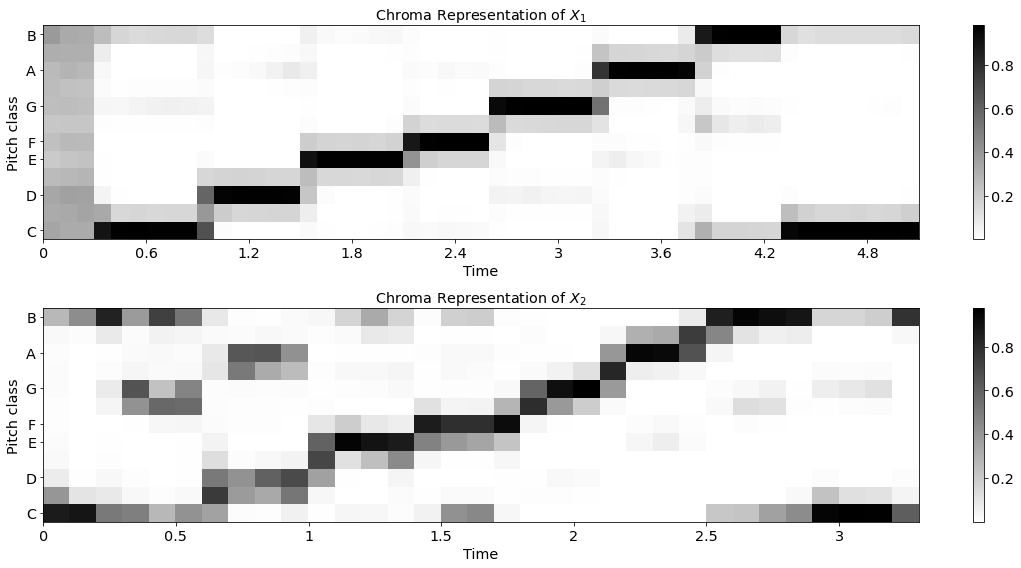

In [ ]:
x_1, fs = librosa.load("/content/drive/MyDrive/labdata/cmajor_piano.wav")
x_2, fs = librosa.load("/content/drive/MyDrive/labdata/Cmajor_sung.wav")
n_fft = 4410
hop_size = 2205 # Used different hop_size instead of nperseg which was used 
                # in above example. This made it more sharp

x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft,
                                         win_length = nperseg1)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft,
                                         win_length = nperseg2)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.title('Chroma Representation of $X_1$')
librosa.display.specshow(x_1_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title('Chroma Representation of $X_2$')
librosa.display.specshow(x_2_chroma, x_axis='time',
                         y_axis='chroma', cmap='gray_r', hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

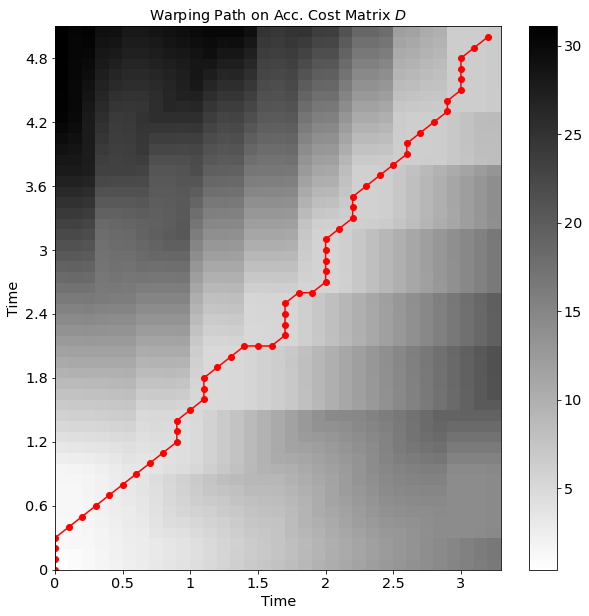

In [ ]:
D, wp = librosa.sequence.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()

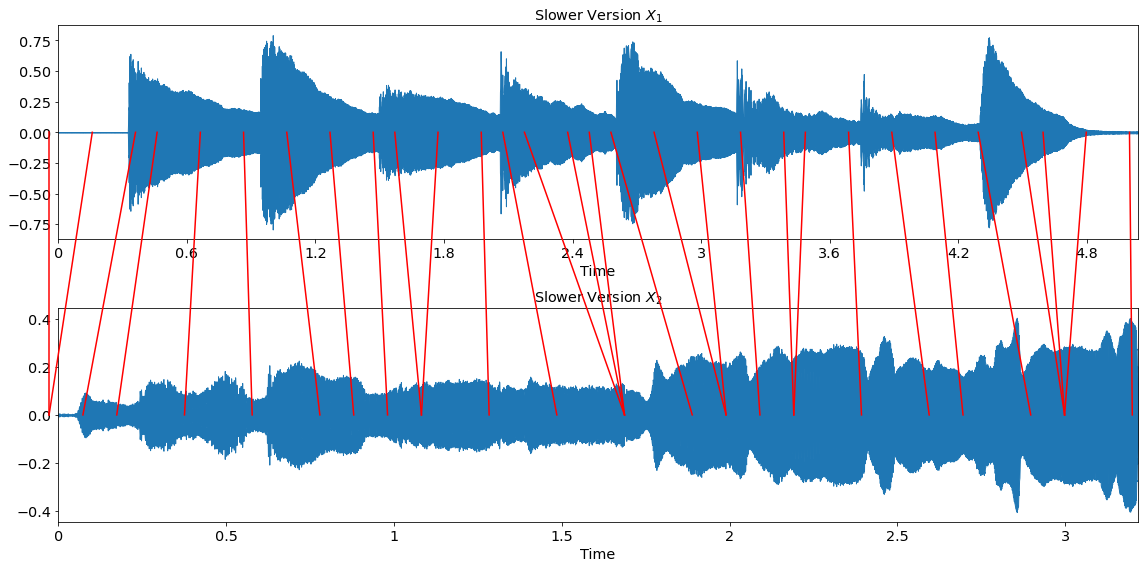

In [ ]:
fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs)
plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs)
plt.title('Slower Version $X_2$')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()

## Part 1.6 Last task: conclude, explore



1.   Compare the alignment obtained from "your" features with those using the librosa features, are they different? If yes, why do you think?
2.   Replace the two simple sound files by two complete songs. You can use the Kafene1 and Kafene2 files in the shared folder, or some other song you like more. Compute the alignment, using the librosa features and provide a plot of the alignment curve. Did it work?
3. Find two files where the alignment does not work, and explain why. Note: this can be e.g. because the two versions differ in form (e.g. Refrain repeated in one version), tuning, or instrumentation. Also: the chroma features work best for harmonic instruments, and for western-tonal music.



1. The difference from our result and the librosa features is the fact that the hop size matters alot. As with a smaller hopsize, the features get more pronounced. 

2. Kafene1 and Kafene2 are very similar how the audio is percieved. This makes the process to align the two audio files much simpler and more efficient. Another cause can be that the audio files are very similar in length which makes it much easier for the dtw algorithm to work.

3. When comparing drumloop120_mono.wav and flute-c-major.wav we can clearly see that the alignment does not work very good. As the two causes of this would the difference in length of audio but also the fact that the drumloop has a clear beat while the fluit audio is much more vibrant. So the structures of the audio is very different which will therefore complicate the costfunction as the distances are very non-coherrent. 

Question 2.

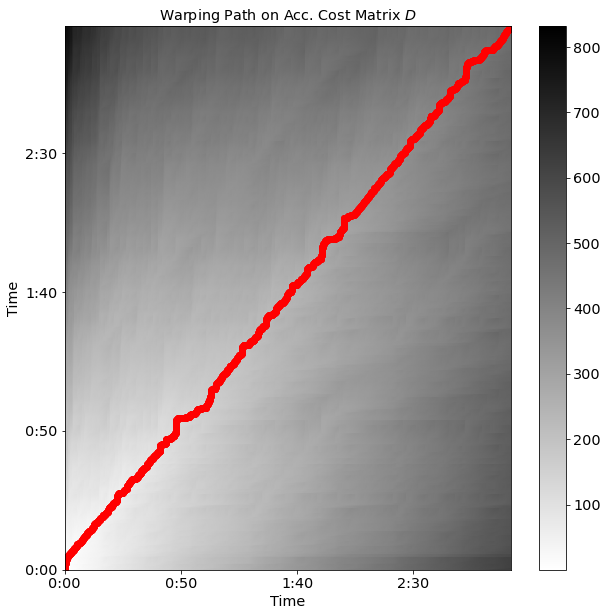

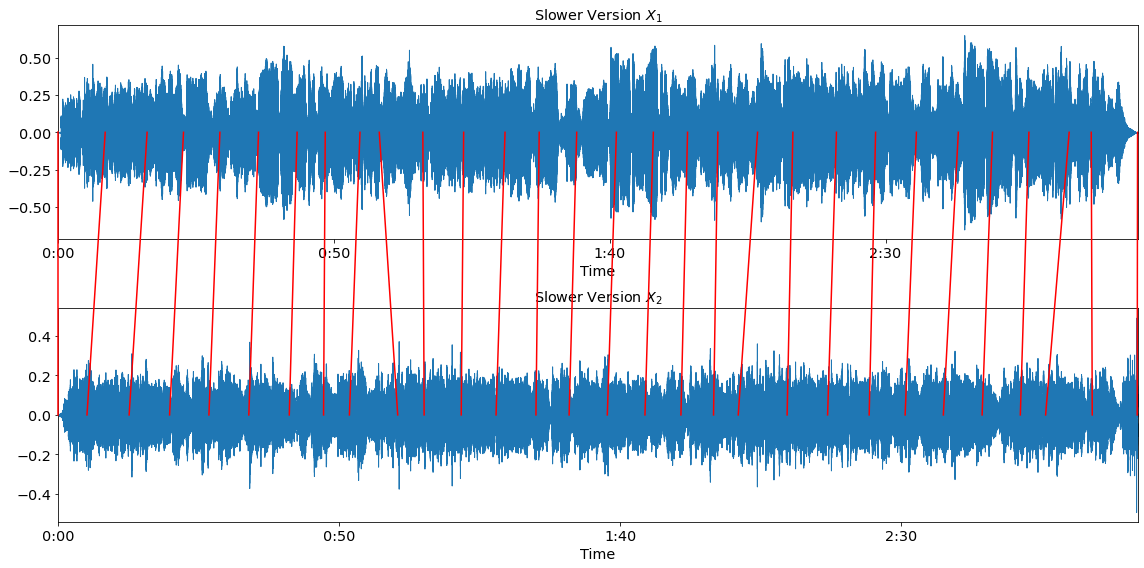

In [ ]:
x_1, fs = librosa.load("/content/drive/MyDrive/labdata/Kafene1.wav")
x_2, fs = librosa.load("/content/drive/MyDrive/labdata/Kafene2.wav")
n_fft = 4410
hop_size = 2205 # Used different hop_size instead of nperseg which was used 
                # in above example. This made it more sharp

x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft,
                                         win_length = nperseg1)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft,
                                         win_length = nperseg2)


D, wp = librosa.sequence.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs)
plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs)
plt.title('Slower Version $X_2$')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()
plt.show()

Question 3.

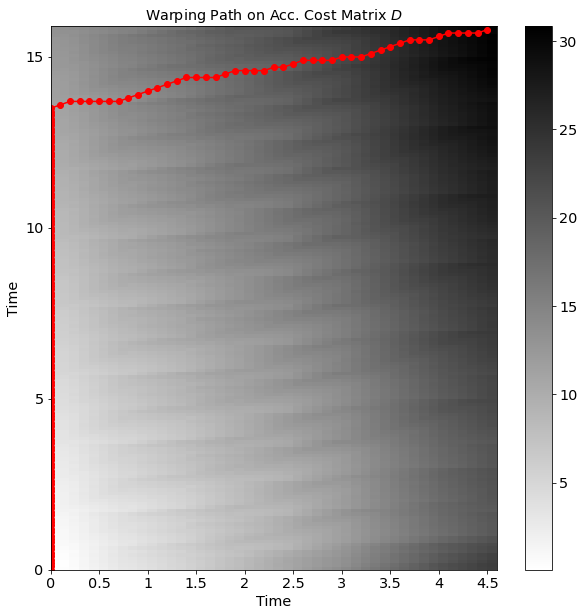

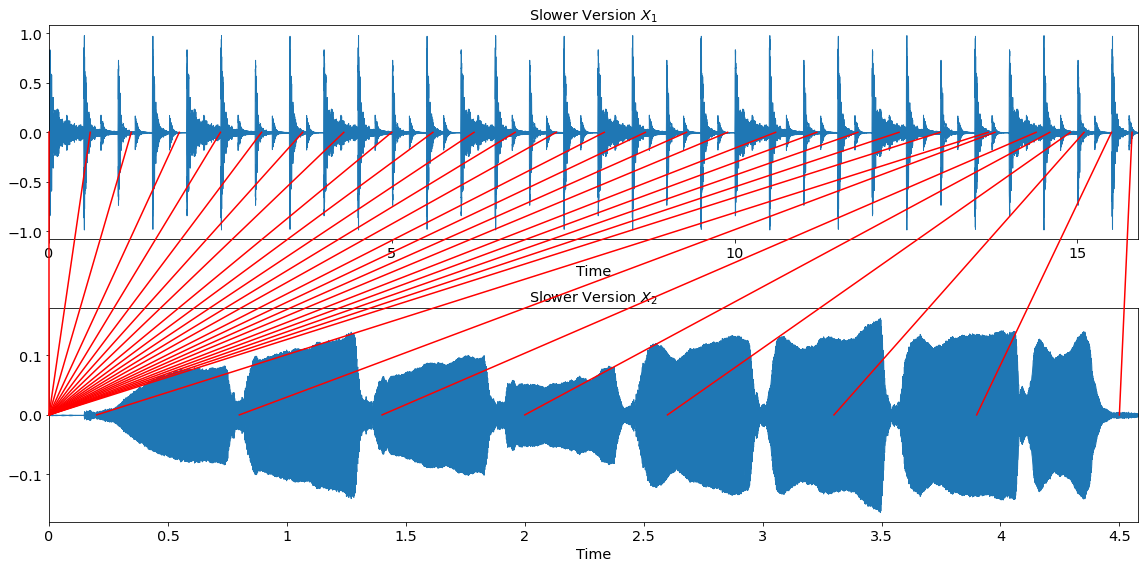

In [ ]:
x_1, fs = librosa.load("/content/drive/MyDrive/labdata/drumloop120_mono.wav")
x_2, fs = librosa.load("/content/drive/MyDrive/labdata/flute-c-major.wav")
n_fft = 4410
hop_size = 2205 # Used different hop_size instead of nperseg which was used 
                # in above example. This made it more sharp

x_1_chroma = librosa.feature.chroma_stft(y=x_1, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft,
                                         win_length = nperseg1)
x_2_chroma = librosa.feature.chroma_stft(y=x_2, sr=fs, tuning=0, norm=2,
                                         hop_length=hop_size, n_fft=n_fft,
                                         win_length = nperseg2)


D, wp = librosa.sequence.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = np.asarray(wp) * hop_size / fs

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(D, x_axis='time', y_axis='time',
                         cmap='gray_r', hop_length=hop_size)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(x_1, sr=fs)
plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(x_2, sr=fs)
plt.title('Slower Version $X_2$')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, wp.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp[points_idx] * hop_size / fs:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()
plt.show()

# 2. Rhythm and tempo processing

In this part, we compute a spectral-based novelty function (often called spectral flux) to obtain onsets, we compute a Fourier tempogram to get tempo estimates, and we compare the beat tracker presented in the book with a recent state-of-the-art beat tracker that uses deep learning (out of the box using available code!).

Show your versions of my plots, and provide us with your code, and answer the questions in the text.

## Part 2.1 Onset detection using spectral-based novelty

In the examples below, I use the drumloop120_mono.wav to obtain the plots.

As a first step, compute a short-time Fourier transform (STFT) magnitude spectrogram, by applying a short window (I use 30ms, and 10ms hop size). Use the code from Lab 1 as starting point to read audio files and compute the STFT.

Then apply logarithmic compression (equation 6.5). Then the log-magnitude spectrum looks as follows for me (with gamma=100):

![](https://drive.google.com/uc?id=1F3Y3_iHy6tIZq2guIeQXIQIKPaONTzNO)

The next step is to compute the difference over time, and to do what is referred to as half-wave rectification in the book (equation 6.6). Plot the obtained matrix, which looks for me as follows:

![](https://drive.google.com/uc?id=17LaxEAAliDfaQ72V807iw4y9FkUdV_SK)

As you can see, the impulses of the drum onsets are emphasized in this representation. 

Now you add this matrix along the columns to get a single vector, which looks as the blue line in the plot below.

![](https://drive.google.com/uc?id=1-iC2NFpeOx65vsbhiyk7-sWZ1NSljWde)

The yellow line shows the local average function (equation 6.7, mu(n)) that we will use for post processing. Hint: in order to obtain the local average function in python you can use the numpy function convolve(), if you google for "moving average" and "np.convolve" you will find examples.

When you subtract mu(n) from the spectral flux vector, and keep only positive values (equation 6.8), you obtain the final spectral novelty function. In addition, normalize the obtained vector so that the maximum is 1. It looks as follows for me (the blue line):

![](https://drive.google.com/uc?id=1rCRnhHkc_sR2d-wGIojRbmkOAAJrwmbb)

Finally, we want to obtain onsets! We do this by thresholding the obtained function, which means determining all points at which the function is larger than a certain number. The dotted red lines show the onsets that I get with a threshold of 0.5. (Hint: the stem function from the matplotlib does that plotting for you)

What is the value you need to set for the threshold to detect all onsets? Try it with another sound file, is the value the same?

Do you observe any other problems with the obtained onset detection?



## Part 2.2 Spectral-based novelty by madmom

Madmom is a python toolbox that does some state-of-the-art rhythm processing for you. The repository is here (along with some tutorials):

https://github.com/CPJKU/madmom

In order to get better novelty features, you can use the code in the following tutorial as starting point:

https://github.com/CPJKU/madmom_tutorials/blob/master/onset_detection.ipynb

You can **run this tutorial as an addition, if you want to understand more** about state-of-the-art signal processing.

In order to use madmom in colab, I have to install it as follows, and to restart the runtime...which means this is better done in a separate python notebook. In order to re-import all libraries and create all needed variables again this separate notebook should start as:



In [ ]:
# Install python library madmom, for onset detection and beat tracking
!pip install --force-reinstall madmom

In [ ]:
!pip install pydub

In [ ]:
import librosa
import librosa.display
import os, sys
from scipy import signal
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import madmom
from scipy.ndimage.filters import maximum_filter
import IPython.display as ipd

filename1 = 'cretansyrtos.wav'#put your file
root_path = 'gdrive/My Drive/Teaching/DT2470/lab2/labdata/'#put your path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Part 2.3 Compute a Fourier tempogram

We will use the above spectral-based novelty function as an input, to compute a tempogram. From this tempogram, we can get an estimate of the tempo of a piece.

Again, produce the figures that I show below. I use the drumloop again, but you can use more interesting music files as well, for instance I provided the "cretansyrtos.wav" as an example of some Cretan folk dance.

So, as a starting point, you need to compute the spectral novelty function (equation 6.8) for whatever sound you intend to use.

The Fourier tempogram then is nothing but the STFT magnitude of the novelty function, with the frequency values mapped to tempo values (equation 6.24). Below you see what I get for a window size of 8 seconds, and a hop size of 0.5 seconds: 

![](https://drive.google.com/uc?id=1vgbnAiJ_vlGeO44j_syyIlTy_Z6FyiHm)

The red line in the above plot is the tempo estimate that I get, when I look for the maximum of the tempogram in each column in a range from 100 to 200 bpm. Implement this tempo estimation, and report also what you obtain when you do not constrain it to a specific tempo range.

## Part 2.4 Beat Tracking

In this part you will use two beat trackers, which are available in python:



1.   The librosa beat tracker, which is the dynamic programming approach presented in the book. An example for how to run the librosa beat tracker: https://musicinformationretrieval.com/beat_tracking.html

2.   And the madmom beat tracker, which is using deep learning. 

Apply both beat trackers to audio examples having the following three characteristics:

1. stable tempo, strong onsets (for instance, the drum loop example) 
2. instable tempo, strong onsets (for instance, the cretansyrtos) 
3. weak energy onsets (for instance, a string quartet or a choir performance) 

Provide plots for the waveform with the beats overlaid (using vlines or stem). Also listen to the beat tracking results, which you can do with code that looks somewhat as follows:



In [ ]:
import IPython.display as ipd
clicks = librosa.clicks(beat_times, sr=sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)

For tracking with madmom, your code should look someshat as shown below. Note that in order to run madmom, I need to install it with the --force-install option, so it might be better to do that in a separate python notebook. A nice example that applies both librosa and madmom is here: https://www.analyticsvidhya.com/blog/2018/02/audio-beat-tracking-for-music-information-retrieval/

In [ ]:
import madmom
proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
act = madmom.features.beats.RNNBeatProcessor()(os.path.join(root_path,filename1))
beat_times = proc(act)


Report what differences you observe (mainly by listening to the audio with the clicks for the beats) between the beat tracking outputs obtained from the two algorithms. Why do you think these differences emerge? (Given what you know from the book chapter and the from example on the analyticsvidhya website)

The plot of waveform and beats I get for the cretansyrtos example using librosa:

![](https://drive.google.com/uc?id=1l1YtJjrCHzaGUDEQ9O4UBafarf983CvW)

The plot of waveform and beats I get for the cretansyrtos example using madmom:

![](https://drive.google.com/uc?id=1L5LHO2EwgHgg8ypuj57gaj2j0eboCa5k)